#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Подготовка

Импортируем необходимые библиотеки.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import lightgbm as lgb
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

Инициализируем глобальные константы.

In [2]:
RANDOM_STATE = 17

NEG_RMSE = 'neg_root_mean_squared_error'
R2 = 'r2'

Загрузим данные и выведем первые пять строк.

In [3]:
taxi_df = pd.read_csv('/datasets/taxi.csv', sep=None, engine='python')
taxi_df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Данные загружены корректно.

Посмотрим, какие типы данных были определены и есть ли пропуски в данных.

In [4]:
taxi_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.1 MB


Пропусков нет.

Выведем статистическую информацию о данных.

datetime
['2018-03-01 00:00:00' '2018-03-01 00:10:00' '2018-03-01 00:20:00' ...
 '2018-08-31 23:30:00' '2018-08-31 23:40:00' '2018-08-31 23:50:00']
2018-04-20 23:20:00    1
2018-04-13 05:40:00    1
2018-04-16 07:50:00    1
2018-03-08 23:30:00    1
2018-03-21 18:50:00    1
                      ..
2018-04-18 01:30:00    1
2018-05-06 04:10:00    1
2018-08-17 10:50:00    1
2018-08-05 14:10:00    1
2018-07-21 07:00:00    1
Name: datetime, Length: 26496, dtype: int64

num_orders
count    26496.000000
mean        14.070463
std          9.211330
min          0.000000
25%          8.000000
50%         13.000000
75%         19.000000
max        119.000000
Name: num_orders, dtype: float64


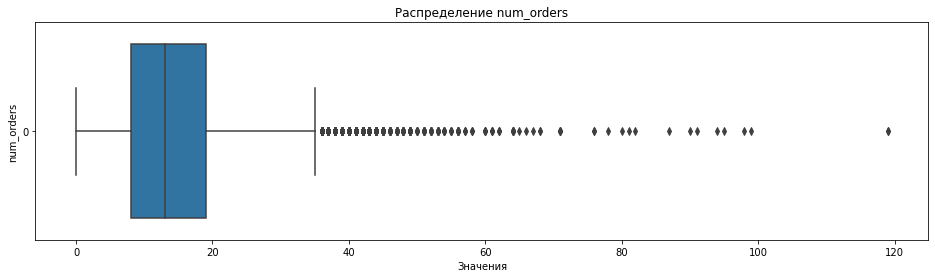

In [5]:
def info(data: pd.DataFrame):
    """
    Функция пробегает по признакам датафрейма и, если тип у признака object,
    выводит уникальные значения и их количество, в противном случае 
    оценивается распределение.
    
    Аргументы
    ---------
    data : pd.DataFrame
        Датафрейм, по которому выводится информация.
        
    Возвращает
    ----------
    None
    """
    for column in data.columns:
        if data[column].dtype == 'object':
            print(column)
            print(data[column].unique())
            print(data[column].value_counts())
            print()
        else:
            print(column)
            print(data[column].describe())
            # Если число уникальных значений в столбце между 1 и длиной столбца, то вывести распределение признака
            if len(data[column].unique()) > 1 and len(data[column].unique()) != len(data[column]):
                plt.figure(figsize=(16, 4))
                sns.boxplot(data=data[column], orient='h')
                plt.xlabel('Значения')
                plt.ylabel(column)
                plt.title('Распределение ' + column)
                plt.show()
                
info(taxi_df)

Видно, что даты не дублируются, а значит, и в данных нет дубликатов. Аномальных значений числа заказов не наблюдается.

Преобразуем столбец 'datetime' в дату-время и заместим им индексы датафрейма.

In [6]:
taxi_df['datetime'] = pd.to_datetime(taxi_df['datetime'])
taxi_df.set_index('datetime', drop=True, inplace=True)
taxi_df.sort_index(inplace=True)
taxi_df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Проведём ресемплинг данных с частотой в один час.

In [7]:
taxi_df = taxi_df.resample('1H', closed='right').sum()
taxi_df.head()

,num_orders
datetime,
2018-02-28 23:00:00,9
2018-03-01 00:00:00,122
2018-03-01 01:00:00,100
2018-03-01 02:00:00,57
2018-03-01 03:00:00,71


### Вывод

* Данные представляют собой таблицу из 26496 строк и 2 столбцов (с датой и целевым признаком).
* Пропущенных значений нет.
* Аномалий в данных не обнаружено.
* Проведён ресемплинг данных с частотой в один час (исходная частота - 1 минута).

## Анализ

Выведем временной ряд на график для общей оценки.

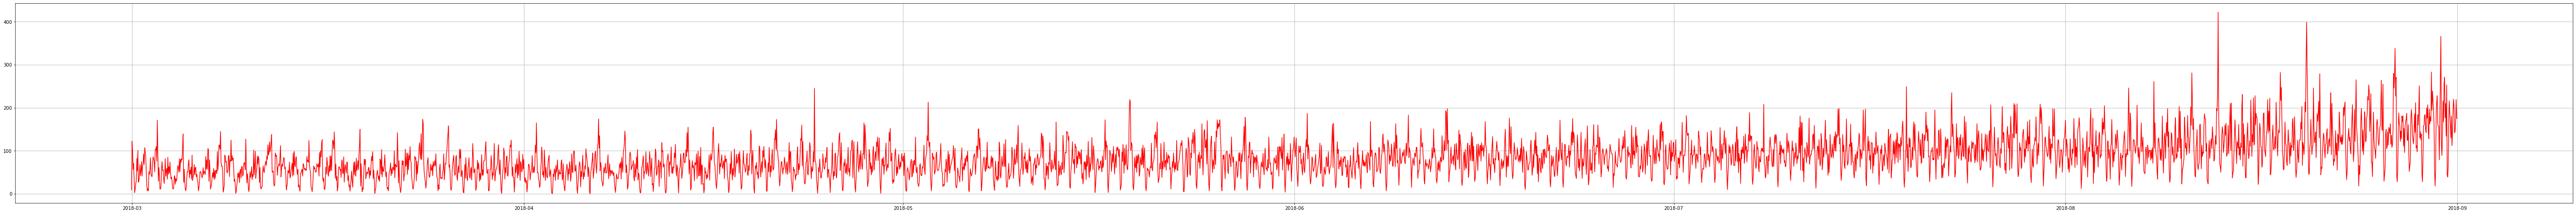

In [8]:
plt.figure(figsize=(100, 8))
plt.plot(taxi_df, '-r')
plt.grid(True)

Заметно наличие тренда и увеличение разброса значений ближе к концу ряда, поэтому скорее всего ряд нестационарный. Проверим предположение тестом Дики-Фуллера.

In [9]:
def print_adfuller_results(series, adf_params={}, alpha=0.05):
    """
    Выводит результаты дополненного теста Дики-Фуллера.
    
    Аргументы
    ---------
    series : array-like, 1-d
        Временной ряд, который будет проверен на стационарность.
    adf_params : dict, default={}
        Аргументы метода statsmodels.tsa.stattools.adfuller.
    alpha : float, default=0.05
        Уровень значимости.
        
    Возвращает
    ----------
    None
    """
    result = adfuller(series, **adf_params)
    if result[1] < alpha:
        print('Нулевая гипотеза о нестационарности временного ряда отвегнута. Ряд стационарный.')
    else:
        print('Нулевая гипотеза о нестационарности временного ряда принята. Ряд нестационарный.')
    print('-'*80)
    
    print('Значение статистики Дики-Фуллера: {:.6}'.format(result[0]))
    print('P-value: {:.6}'.format(result[1]))
    print('Количество использованных лагов: {}'.format(result[2]))
    
    print('Критические значения:')
    for key, value in result[4].items():
        print('{}, {:.6}'.format(key, value))
        
def plot_acf_pacf(series, nlags = 50):
    """
    Строит графики функций автокорреляции и частной автокорреляции.
    
    Аргументы
    ---------
    series : array-like, 1-d
        Временной ряд или любой одномерный массив, содержащий числа.
    nlags : int, default=50
        Число используемых лагов.
        
    Возвращает
    ----------
    None
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    plot_acf(series, lags=nlags, ax=axes[0])
    plot_pacf(series, lags=nlags, ax=axes[1]);

Выведем результаты теста и графики функций автокорреляции и частной автокорреляции для максимальной уверенности.

Нулевая гипотеза о нестационарности временного ряда принята. Ряд нестационарный.
--------------------------------------------------------------------------------
Значение статистики Дики-Фуллера: -3.02654
P-value: 0.0324888
Количество использованных лагов: 29
Критические значения:
1%, -3.43184
5%, -2.8622
10%, -2.56712


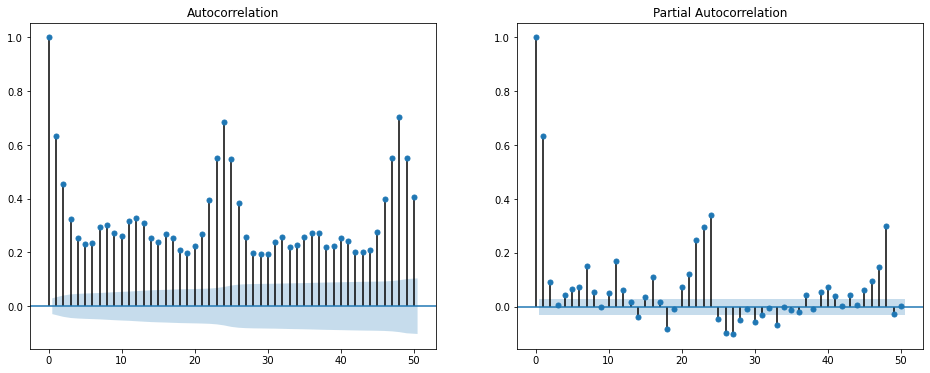

In [10]:
print_adfuller_results(taxi_df['num_orders'], {'autolag': 'AIC'}, alpha=0.01)
plot_acf_pacf(taxi_df['num_orders'])

Разложим ряд на аддитивные компоненты: тренд, сезонность и остатки - для детального анализа.

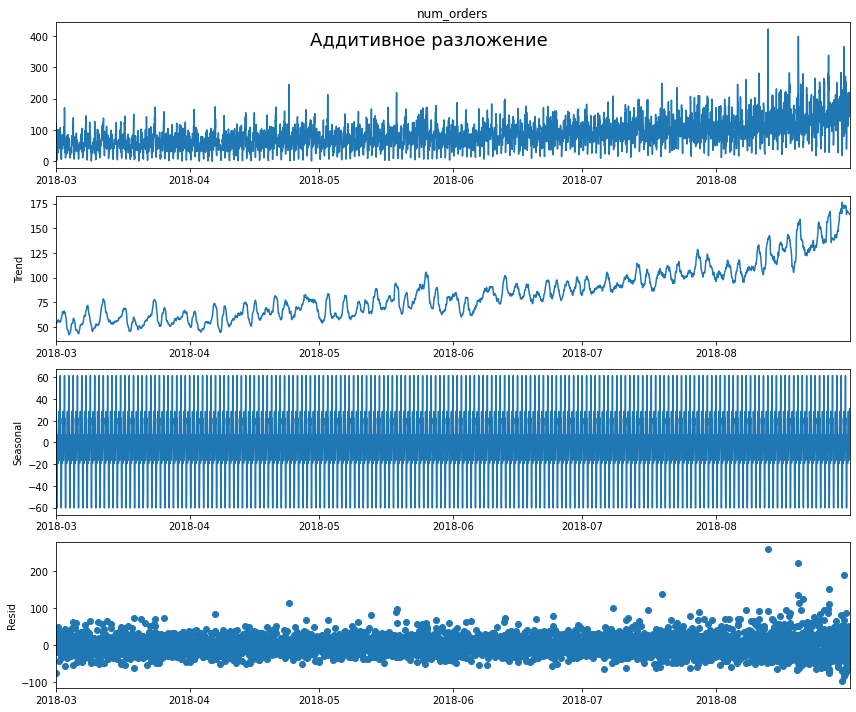

In [11]:
decomposed_add = seasonal_decompose(taxi_df['num_orders'], model='additive', extrapolate_trend='freq')

plt.rcParams.update({'figure.figsize': (12, 10)})
decomposed_add.plot().suptitle('Аддитивное разложение', fontsize=18, y=0.95)
plt.show()

Рассмотрим сезонные колебания в недельном интервале.

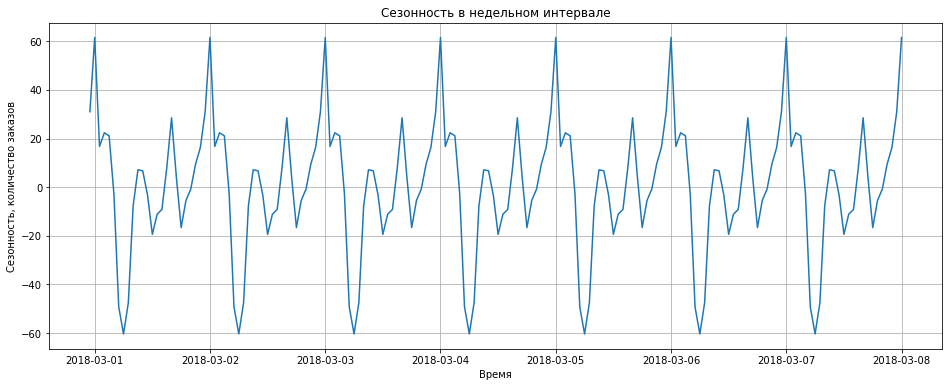

In [102]:
plt.figure(figsize=(16, 6))
plt.plot(decomposed_add.seasonal[:170])
plt.grid(True)
plt.title('Сезонность в недельном интервале')
plt.xlabel('Время')
plt.ylabel('Сезонность, количество заказов')
plt.show()

Видны повторяющиеся пики с суточным интервалом. Похоже, максимальный спрос приходится на полночь, а минимальный - в районе 6 часов утра. Проверим суточные колебания.

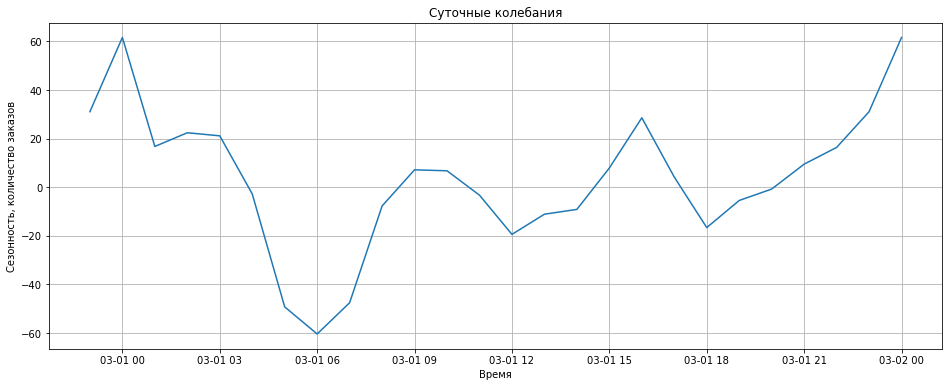

In [101]:
plt.figure(figsize=(16, 6))
plt.plot(decomposed_add.seasonal[:26])
plt.grid(True)
plt.title('Суточные колебания')
plt.xlabel('Время')
plt.ylabel('Сезонность, количество заказов')
plt.show()

Да, в 6 часов минимальный спрос. В 12 и 18 видны локальные минимумы, при этом 12й лаг чуть лучше коррелирует с исходным рядом, чем 18й, а 6й лаг слабо коррелирует. Используем эту информацию при генерации признакового пространства.

Проанализируем колебания спроса в течение недели.

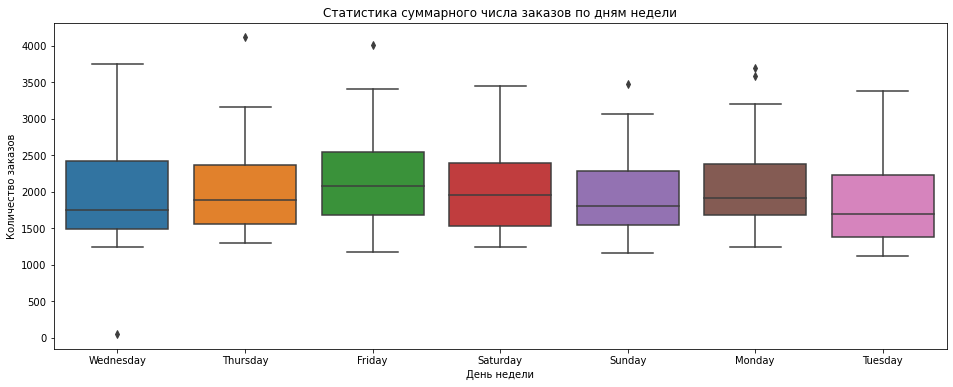

In [113]:
plt.figure(figsize=(16, 6))
trend_resampled = decomposed_add.trend.resample('1d').sum()
sns.boxplot(trend_resampled.index.day_name(), trend_resampled)
plt.title('Статистика суммарного числа заказов по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество заказов')
plt.show()

Заметно, что в пятницу наибольшее среднее суммарное число заказов, при этом во вторник и среду средние значения самые низкие, а значит, можно говорить о колебаниях спроса в течение недели.

Наполним признаковое пространство.  
Напишем функцию для добавления признака, вычисленного на скользящем окне.

In [17]:
def add_rolling(df: pd.DataFrame, target_col: str,  window_size: int, agg_func: str):
    """
    Добавляет столбец со значениями, вычисленными по целевому столбцу методом скользящего окна.
    Для каждого значения целевого столбца выводит агрегированное по выбранной функции, при этом правая граница окна
    соответствует предыдущему значению.
    
    Аргументы
    ---------
    df : pandas.DataFrame
        Исходный датафрейм.
    target_col : str
        Название целевого столбца.
    window_size : int
        Размер скользящего окна.
    agg_func : str
        Функция, по которой агрегируются значения внутри скользящего окна.
        
    Возвращает
    ----------
    None
    """
    try:
        exec("df['rolling_' + agg_func + '_' + str(window_size)] =\
                df[target_col].shift().rolling(window=window_size)." + agg_func + '()')
    except Exception as e:
        print('Error:', e)

Добавим лаги 1, 12, 24, соответствующий суточному сдвигу и 168, соответствующий недельному сдвигу, а также скользящее среднее с размером окна в 6 часов.

In [18]:
lags_list = [1, 12, 24, 168]
for lag in lags_list:
    taxi_df['lag_'+str(lag)] = taxi_df['num_orders'].shift(lag)

add_rolling(df=taxi_df, target_col='num_orders', window_size=6, agg_func='mean')
taxi_df.dropna().head()

,num_orders,lag_1,lag_12,lag_24,lag_168,rolling_mean_6
datetime,,,,,,
2018-03-07 23:00:00,104,113.0,59.0,57.0,9.0,83.333333
2018-03-08 00:00:00,145,104.0,33.0,105.0,122.0,92.833333
2018-03-08 01:00:00,74,145.0,54.0,104.0,100.0,100.666667
2018-03-08 02:00:00,64,74.0,36.0,29.0,57.0,104.000000
2018-03-08 03:00:00,65,64.0,55.0,79.0,71.0,102.166667


Создадим два календарных признака: час и день недели. Так как эти признаки имеют циклический характер, то необходимо указать на это модели с помощью циклических же функций (например, синуса или косинуса). Это нужно для того, чтобы модель "увидела" близость как 0 и 1 часов, так и 23 и 0; как 0 и 1 дней недели, так и 6 и 0.

In [19]:
taxi_df['hour'] = np.sin(taxi_df.index.hour * np.pi / 12)
taxi_df['day_of_week'] = np.sin(2 * taxi_df.index.dayofweek * np.pi / 7)
taxi_df.dropna().head()

,num_orders,lag_1,lag_12,lag_24,lag_168,rolling_mean_6,hour,day_of_week
datetime,,,,,,,,
2018-03-07 23:00:00,104,113.0,59.0,57.0,9.0,83.333333,-0.258819,0.974928
2018-03-08 00:00:00,145,104.0,33.0,105.0,122.0,92.833333,0.000000,0.433884
2018-03-08 01:00:00,74,145.0,54.0,104.0,100.0,100.666667,0.258819,0.433884
2018-03-08 02:00:00,64,74.0,36.0,29.0,57.0,104.000000,0.500000,0.433884
2018-03-08 03:00:00,65,64.0,55.0,79.0,71.0,102.166667,0.707107,0.433884


Проведём корреляционный анализ для отбора подходящих признаков для обучения.

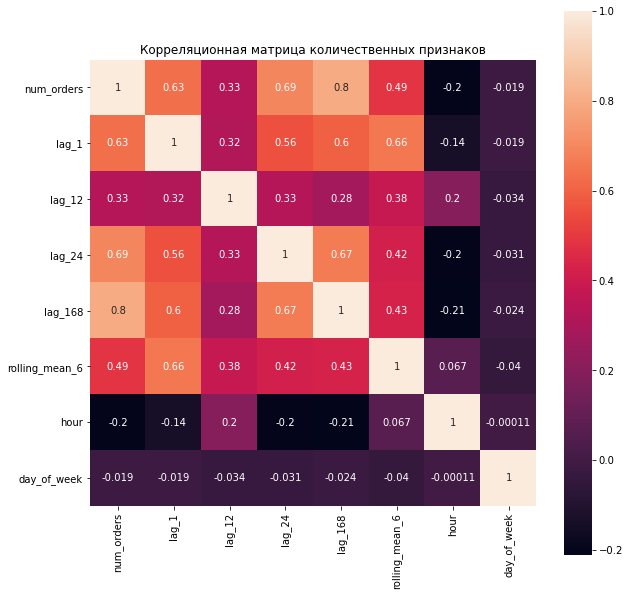

In [20]:
corr_matrix = taxi_df.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, robust=True, square=True, annot=True)

plt.title('Корреляционная матрица количественных признаков')
plt.show()

Видно, что некоторые регрессоры средне коррелируют между собой, однако сильной линейной зависимости между ними нет. С целевым признаком регрессоры коррелируют достаточно хорошо, за исключением часа и дня недели, оставим в наборе все признаки.

Разобъём данные на множества регрессоров и целевого признака.

In [21]:
features = taxi_df.dropna().drop(columns=['num_orders'])
target = taxi_df.dropna()['num_orders']

### Вывод

* В результате анализа временного ряда количества заказов выявлены:
    * нестационарность ряда;
    * сезонность с суточным периодом;
    * колебания спроса в течение дня:
        * максимальные пики в 0 часов;
        * пики минимумов в 6, 12 и 18 часов.
    * колебания спроса в течение недели: максимум среднего суммарного числа заказов приходится на пятницу, минимум - на вторник и среду.
* Сгенерированы признаки на основе даты-времени:
    * час и день недели.
* и целевого признака:
    * лаги 1, 12, 24, соответствующий суточному сдвигу и 168, соответствующий недельному сдвигу, а также скользящее среднее с размером окна в 6 часов.
* Проведён корреляционный анализ признаков. Сильной мультиколлинеарности обнаружено не было, регрессоры хорошо коррелируют с целевым признаком.

## Обучение

Разделим регрессоры и целевой признак на обучающее и тестовое подмножества в соотношении 9:1.

In [22]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, shuffle=False, test_size=0.1
)
features_train.shape, features_test.shape, target_train.shape, target_test.shape

((3824, 7), (425, 7), (3824,), (425,))

Создадим пайплайны с предварительной стандартизацией и моделями линейной регрессии и градиентным бустингом из библиотеки LightGBM и проведём кросс-валидацию при параметрах по умолчанию - так мы получим базовое качество моделей. Результаты кросс-валидации запишем в сводную таблицу.

In [23]:
pipes_dict = {
    'Линейная регрессия': Pipeline(
        [
            ('scaler', StandardScaler()),
            ('lin_reg', LinearRegression(n_jobs=-1))
        ]
    ),
    'Градиентный бустинг LightGBM': Pipeline(
        [
            ('scaler', StandardScaler()),
            ('lgb_reg', lgb.LGBMRegressor(random_state=RANDOM_STATE))
        ]
    )
}

scoring_dict = {'RMSE': NEG_RMSE, 'R^2': R2}

time_split = TimeSeriesSplit()

cv_scores_dict = {
    desc:
    [
        cross_val_score(
            estimator=pipe,
            X=features_train,
            y=target_train,
            scoring=scoring,
            cv=time_split,
            n_jobs=-1
        )
        for pipe in pipes_dict.values()
    ]
    for desc, scoring in scoring_dict.items()
}
        
scores_dict = {
    desc:
    [
        abs(cv_scores.mean())
        for cv_scores in cv_scores_dict[desc]
    ]
    for desc in scoring_dict
}

multicols = [['Обучение']*2 + ['Валидация']*2]
multicols.append([scoring for scoring in scoring_dict]*2)

score_df = pd.DataFrame(data=[], index=pipes_dict.keys(), columns=multicols)
[
    exec('score_df["Валидация", score_name] = scores_dict[score_name]')
    for score_name in scoring_dict
]
        
score_df

Обучение       Валидация          
                                 RMSE  R^2       RMSE       R^2
Линейная регрессия                NaN  NaN  23.182478  0.574220
Градиентный бустинг LightGBM      NaN  NaN  23.774051  0.550871

Добавим качество бейслайнов на обучающей выборке.

In [24]:
scoring_dict = {'RMSE': mean_squared_error, 'R^2': r2_score}

for pipe in pipes_dict.values():
    pipe.fit(features_train, target_train)

scores_dict = {
    desc:
    [
        scoring(target_train, pipe.predict(features_train), squared=False)
        if desc == 'RMSE'
        else scoring(target_train, pipe.predict(features_train))
        for pipe in pipes_dict.values()
    ]
    for desc, scoring in scoring_dict.items()
}

[
    exec('score_df["Обучение", score_name] = scores_dict[score_name]')
    for score_name in scoring_dict
]
        
score_df

Обучение            Валидация          
                                   RMSE       R^2       RMSE       R^2
Линейная регрессия            22.596286  0.661841  23.182478  0.574220
Градиентный бустинг LightGBM  15.409117  0.842746  23.774051  0.550871

Видно, что линейная регрессия показала качество чуть лучше на валидации, при этом градиентный бустинг переобучился, что потребует настройки гиперпараметров.

Визуализируем веса каждого признака, рассчитанные линейной регрессией.

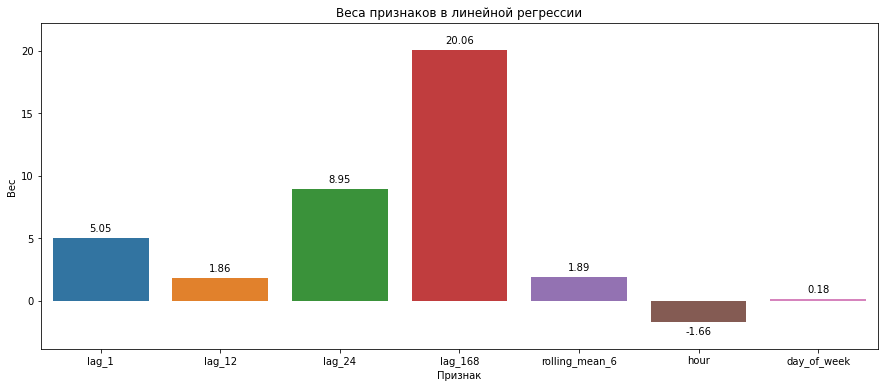

In [25]:
weight_list = pipes_dict['Линейная регрессия'].steps[1][1].coef_
plt.figure(figsize=(15, 6))
g = sns.barplot(x=features.columns, y=weight_list)

for i, weight in enumerate(weight_list):
    g.text(x=i, y=weight + np.sign(weight)*0.75 - 0.25, s=round(weight, 2), color='black', ha='center')

plt.title('Веса признаков в линейной регрессии')
plt.xlabel('Признак')
scale = weight_list.max() - weight_list.min()
plt.ylim((weight_list.min() - scale*0.1, weight_list.max() + scale*0.1))
plt.ylabel('Вес')
plt.show()

Здесь видно, что недельный лаг сильнее всего влияет на целевой признак: при его изменении и неизменных значениях остальных регрессоров целевой признак изменится в 20 раз. Так же сильно влияют дневной лаг и 1-й лаг; слабее всего на целевой признак влияет день недели.

Посмотрим на важность признаков в модели градиентный бустинг.

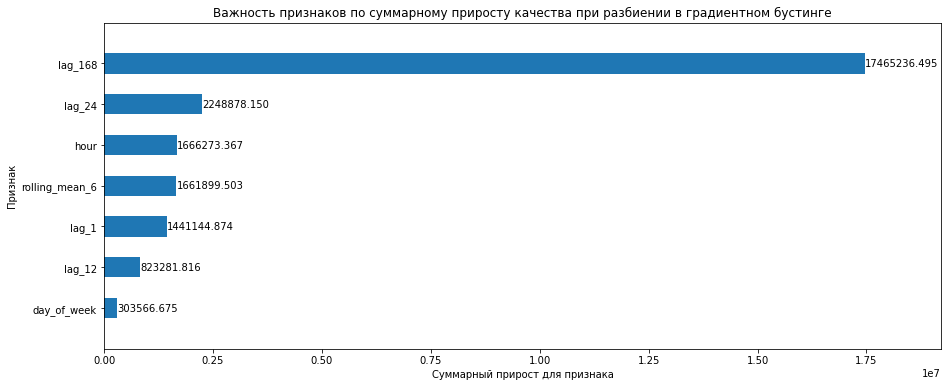

In [26]:
model = pipes_dict['Градиентный бустинг LightGBM'].steps[1][1]

ax = lgb.plot_importance(
    booster=model,
    importance_type ='gain',
    title='Важность признаков по суммарному приросту качества при разбиении в градиентном бустинге',
    xlabel='Суммарный прирост для признака',
    ylabel='Признак',
    figsize=(15, 6),
    height=0.5,
    grid=False
)

feature_map = {col: name for col, name in zip(model.feature_name_, features.columns)}
yticklabels = [feature_map[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(yticklabels);

Здесь недельный лаг дал наибольший суммарный прирост по качеству при построении деревьев, а день недели - наименьший.

Подберём гиперпараметры для градиентного бустинга. Необходимо регуляризовать деревья, например, небольшим значением глубины, большим минимальным числом объектов на листе и т.п.

In [27]:
cv_params = {
    'lgb_reg__n_estimators': range(50, 250, 50),
    'lgb_reg__max_depth': range(2, 10),
    'lgb_reg__num_leaves': range(10, 80, 10),
    'lgb_reg__min_child_samples': range(20, 110, 10)
}

lgb_cv = RandomizedSearchCV(
    estimator=pipes_dict['Градиентный бустинг LightGBM'],
    param_distributions=cv_params,
    n_iter=100,
    scoring=NEG_RMSE,
    n_jobs=-1,
    cv=time_split,
    random_state=RANDOM_STATE,
    return_train_score=True
)

lgb_cv.fit(features_train, target_train)

RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('lgb_reg',
                                              LGBMRegressor(random_state=17))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'lgb_reg__max_depth': range(2, 10),
                                        'lgb_reg__min_child_samples': range(20, 110, 10),
                                        'lgb_reg__n_estimators': range(50, 250, 50),
                                        'lgb_reg__num_leaves': range(10, 80, 10)},
                   random_state=17, return_train_score=True,
                   scoring='neg_root_mean_squared_error')

Выведем лучшие гиперпараметры.

In [28]:
lgb_cv.best_params_

{'lgb_reg__num_leaves': 60,
 'lgb_reg__n_estimators': 150,
 'lgb_reg__min_child_samples': 30,
 'lgb_reg__max_depth': 2}

Выведем лучший результат на кросс-валидации.

In [29]:
-lgb_cv.best_score_

22.95687662175988

Как видно, качество модели выросло чуть больше чем на 3%.  
Выведем результаты при соответствующих гиперпараметрах на тренировочной выборке.

In [30]:
-lgb_cv.cv_results_['mean_train_score'][lgb_cv.cv_results_['mean_test_score'] == lgb_cv.best_score_][0]

17.281891582913218

Переобучение удалось немного уменьшить, но оно всё ещё присутствует.

### Вывод

* Выбраны модели линейной регрессии и градиентного бустинга из библиотеки LightGBM.
* Модели были обучены с настройками по умолчанию. Измерено качество с помощью кросс-валидации:
```
                                 Обучение             	Валидация
                                 RMSE		 R^2		 RMSE		 R^2
Линейная регрессия             22.596286	0.661841	23.182478	0.574220
Градиентный бустинг LightGBM   15.409117	0.842746	23.774051	0.550871
```

* Проведён подбор гиперпараметров с помощью поиска по случайной сетке.
* Лучшие гиперпараметры:
    * Градиентный бустинг LightGBM:
        * максимальное число листьев: 60,
        * число деревьев: 150,
        * минимальное число объектов на листе: 30,
        * максимальная глубина дерева: 2.
* Качество модели после настройки:
    * градиентный бустинг LightGBM, RMSE = 22.96 (**-3.4**%)

## Тестирование

Получим прогнозы для тестовой выборки и измерим качество линейной регрессии.

In [36]:
lin_pipe = pipes_dict['Линейная регрессия']

lin_pipe.fit(features_train, target_train)
lin_predictions = lin_pipe.predict(features_test)

lin_rmse = mean_squared_error(target_test, lin_predictions, squared=False)
print('Линейная регрессия, RMSE = {:.3f}'.format(lin_rmse))

Линейная регрессия, RMSE = 36.188


Получим прогнозы для тестовой выборки и измерим качество градиентного бустинга, подставив лучшие гиперпараметры.

In [37]:
lgb_pipe = pipes_dict['Градиентный бустинг LightGBM'].set_params(**lgb_cv.best_params_)

lgb_pipe.fit(features_train, target_train)
lgb_predictions = lgb_pipe.predict(features_test)

lgb_rmse = mean_squared_error(target_test, lgb_predictions, squared=False)
print('Градиентный бустинг LightGBM, RMSE = {:.3f}'.format(lgb_rmse))

Градиентный бустинг LightGBM, RMSE = 39.037


Как видно, качество моделей хуже, чем на обучающей выборке, но при этом модели прошли порог по метрике RMSE = 48.

Построим диаграммы рассеяния и графики регрессионных остатков для визуального анализа результатов тестирования. Проверим регрессионные остатки на стационарность.

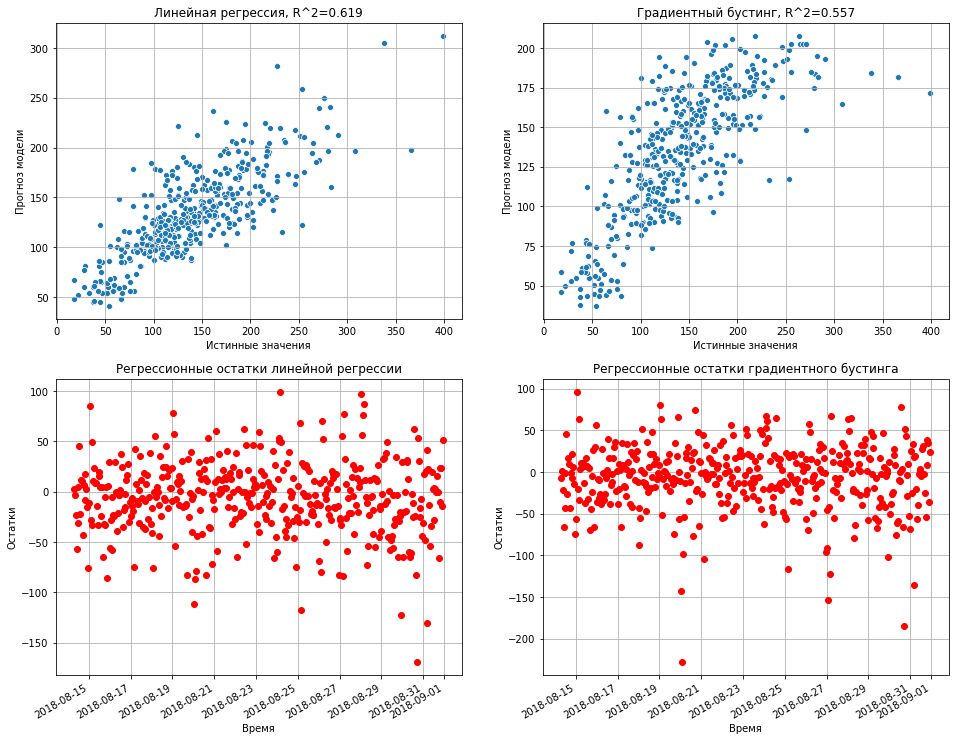

Результаты теста остатков линейной регрессии на стационарность
Нулевая гипотеза о нестационарности временного ряда отвегнута. Ряд стационарный.
--------------------------------------------------------------------------------
Значение статистики Дики-Фуллера: -18.7663
P-value: 2.02572e-30
Количество использованных лагов: 0
Критические значения:
1%, -3.44587
5%, -2.86838
10%, -2.57041

Результаты теста остатков регрессии градиентным бустингом на стационарность
Нулевая гипотеза о нестационарности временного ряда отвегнута. Ряд стационарный.
--------------------------------------------------------------------------------
Значение статистики Дики-Фуллера: -17.316
P-value: 5.51757e-30
Количество использованных лагов: 0
Критические значения:
1%, -3.44587
5%, -2.86838
10%, -2.57041


In [70]:
plt.figure(figsize=(16, 12))

lin_r2 = r2_score(target_test, lin_predictions)
plt.subplot(221, title='Линейная регрессия, R^2=' + '{:.3}'.format(lin_r2))
sns.scatterplot(x=target_test, y=lin_predictions)
plt.xlabel('Истинные значения')
plt.ylabel('Прогноз модели')
plt.grid(True)

lgb_r2 = r2_score(target_test, lgb_predictions)
plt.subplot(222, title='Градиентный бустинг, R^2=' + '{:.3}'.format(lgb_r2))
sns.scatterplot(x=target_test, y=lgb_predictions)
plt.xlabel('Истинные значения')
plt.ylabel('Прогноз модели')
plt.grid(True)

plt.subplot(223, title='Регрессионные остатки линейной регрессии')
lin_errors = pd.Series(lin_predictions, index=target_test.index) - target_test
plt.plot(target_test.index, lin_errors, 'ro')
plt.xticks(rotation=30, ha='right')
plt.xlabel('Время')
plt.ylabel('Остатки')
plt.grid(True)

plt.subplot(224, title='Регрессионные остатки градиентного бустинга')
lgb_errors = pd.Series(lgb_predictions, index=target_test.index) - target_test
plt.plot(target_test.index, lgb_errors, 'ro')
plt.xticks(rotation=30, ha='right')
plt.xlabel('Время')
plt.ylabel('Остатки')
plt.grid(True)
plt.show()

print('Результаты теста остатков линейной регрессии на стационарность')
print_adfuller_results(lin_errors)
print()
print('Результаты теста остатков регрессии градиентным бустингом на стационарность')
print_adfuller_results(lgb_errors)

Коэффициент детерминации для обеих моделей получен удовлетворительный. По остаткам видно, что модели плохо определяют пики в тестовом наборе данных, так как скорее всего их не было в обучающем наборе. Остатки стационарны, значит, тест не обнаружил тренда и изменения дисперсии со временем.

Посчитаем дополнительно RMSE для простой модели, которая прогнозирует целевой признак на основе его предыдущих значений (1-й лаг).

In [33]:
predictions = target_test.shift().fillna(target_train[-1])
simple_rmse = mean_squared_error(target_test, predictions, squared=False)
print('Прогноз по предыдущему значению, RMSE = {:.3f}'.format(simple_rmse))

Прогноз по предыдущему значению, RMSE = 57.780


Получилось хуже, чем у моделей машинного обучения, что является хорошим знаком.

Проверим дополнительно полученные модели на адекватность: обучим фиктивную модель регрессии по двум стратегиям (среднее и медиана).

In [34]:
strategy = ['mean', 'median']
dum_pipes = [Pipeline([('scaler', StandardScaler()), ('dum_reg', DummyRegressor(strategy=s))]) for s in strategy]

[dum_pipe.fit(features_train, target_train) for dum_pipe in dum_pipes]

predictions_list = [dum_pipe.predict(features_test) for dum_pipe in dum_pipes]
dum_rmse_list = [mean_squared_error(target_test, predictions, squared=False) for predictions in predictions_list]

Построим график, чтобы понять наверняка: адекватны ли модели или нет.

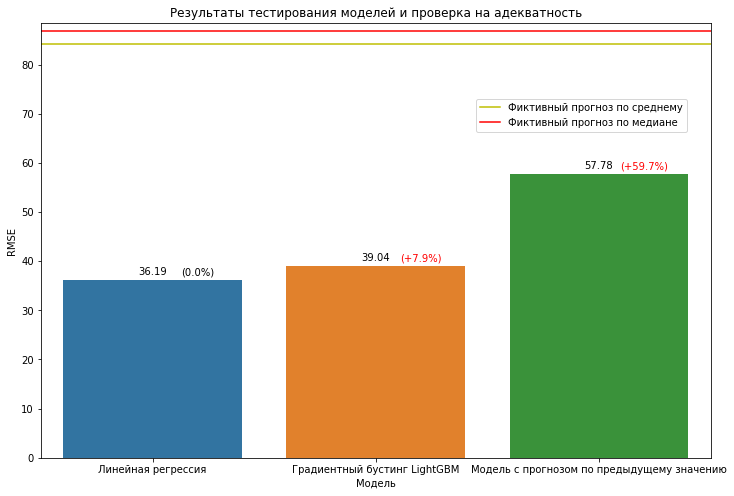

In [35]:
rmse_array = np.array([lin_rmse, lgb_rmse, simple_rmse])
best_rmse = rmse_array.min()
diff_array = (rmse_array - best_rmse) / best_rmse * 100

score_df = pd.DataFrame(
    {'model': [desc for desc in pipes_dict] + ['Модель с прогнозом по предыдущему значению'],
     'rmse': rmse_array,
     'difference': diff_array
    }
)

plt.figure(figsize=(12, 8))
g = sns.barplot(x='model', y='rmse', data=score_df)
plt.axhline(y=dum_rmse_list[0], color='y', linestyle='-', label='Фиктивный прогноз по среднему')
plt.axhline(y=dum_rmse_list[1], color='r', linestyle='-', label='Фиктивный прогноз по медиане')

for index, row in score_df.iterrows():
    g.text(x=index, y=row.rmse + 1Построим график, чтобы понять наверняка: адекватны ли модели или нет., s=round(row.rmse, 2), color='black', ha='center')
    if row.difference > 0:
        clr='red'
        prefix = '+'
    else:
        clr='black'
        prefix = ''
    g.text(x=index+0.2, y=row.rmse + 1, s='(' + prefix + str(round(row.difference, 1)) + '%)', color=clr, ha='center')

plt.legend(loc=(0.65, 0.75))
plt.title('Результаты тестирования моделей и проверка на адекватность')
plt.xlabel('Модель')
plt.ylabel('RMSE');

Видно, что все модели показали адекватный результат, лучший результат у модели линейной регрессии.

### Вывод

* Результаты тестирования моделей:
    * линейная регрессия, RMSE = 36.19 (лучший результат из выбранных моделей МО)
    * градиентный бустинг LightGBM, RMSE = 39.04
    * модель с прогнозом по предыдущему значению, RMSE = 57.78
* Все выбранные модели МО успешно прошли проверку на адекватность и показали качество лучше порогового RMSE = 48.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48